## Modelo para prever Decisões em Processos Judiciais
##### Autor: Ramon Jeronimo de Souza
<h4> </h4>

<h4>Dados:</h4>
<p style="color:white">Dataset: base_decisões_processos_judiciais.csv</p>
<h4> </h4>
<h4>Colunas:</h4>
<p style="color:white">ID: Identificados de cada pedido;</p>
<p style="color:white">Objeto: O pedido dos autores nos processos;</p>
<p style="color:white">Decisão: Decisão no processo atrelada a cada pedido;</p>
<p style="color:white">Instância: Etapa da fase de conhecimento;</p>
<p style="color:white">Data Citação: Data de Citação no processo;</p>
<p style="color:white">Data Decisão: Data da Decisão no processo;</p>
<p style="color:white">Status: Status do processo;</p>
<p style="color:white">Justiça: Estadual, Federal ou Trabalhista;</p>
<p style="color:white">UF: Unidade da Federação;</p>
<p style="color:white">Tribunal: Vara responsável pelo processo;</p>
<p style="color:white">Num. Litisconsortes: Número de autores do processo.</p>
<h4> </h4>

##### 1- Bibliotecas Utilizadas no Estudo

In [70]:
# Carregar bibliotecas: 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from ipywidgets import interactive
from IPython.display import SVG
from IPython.display import display
from IPython.display import Image
import pydotplus
from graphviz import Source

##### 2- Funções criadas para Análise

In [11]:
# Funções criadas:
# Analisar atributos mais importantes:
def categories_importances(model, data_train):
    feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    plt.figure(figsize = (6, 6))
    feat_importances.nlargest(5).plot(kind='barh')
    plt.title("Feature Importance")
    
    
# Navegando na estrutura da arvore de decisão:
def path_tree(model, X_train):
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    print("Número de nós: {}".format(n_nodes))
    
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1
    
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
    
        print("\nA arvore binária tem %s nós e a seguinte estrutura: \n"
          % n_nodes)
    for i in range(n_nodes):
        if is_leaves[i]:
            print("%snó=%s (nó folha)." % (node_depth[i] * "\t", i))
        else:
            print("%snó=%s (nó teste): vai para o nó %s se o valor do atributo %s <= %s \n se não, vai para o "
                  "nó %s."
                  % (node_depth[i] * "\t",
                     i,
                     children_left[i],
                     X_train.columns[feature[i]],
                     threshold[i],
                     children_right[i],
                     ))

            
# Validação cruazada:
def intervalo_accuracy(model, X_train, y_train):
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    result = cross_val_score(model, X_train, 
                          y_train, cv = cv, scoring = 'accuracy')
    mean = result.mean()
    dv = result.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'
           .format((mean - 2*dv)*100, (mean + 2*dv)*100))
    

# Intervalo de Precisão:
def intervalo_precisao(model, X_train, y_train):
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    result = cross_val_score(model, X_train, 
                          y_train, cv = cv, scoring = 'precision')
    mean = result.mean()
    dv = result.std()
    print('Precisão média: {:.2f}%'.format(mean*100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'
          .format((mean - 2*dv)*100, (mean + 2*dv)*100))
    
    
# Intervalo de Recall:
def intervalo_recall(model, X_train, y_train):
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    result = cross_val_score(model, X_train, 
                          y_train, cv = cv, scoring = 'recall')
    mean = result.mean()
    dv = result.std()
    print('Recall média: {:.2f}%'.format(mean*100))
    print('Intervalo de Recall: [{:.2f}% ~ {:.2f}%]'
          .format((mean - 2*dv)*100, (mean + 2*dv)*100))
    
    
# Trade-off de Precisão x Recall
def tradeoff_precisao_recall(model, X_train, y_train):
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    y_scores = cross_val_predict(model, X_train, y_train, 
                                  cv = cv, method = 'predict_proba')
    precisions, recalls, thresholds = precision_recall_curve(y_train,  
                                                             y_scores)
    
    
# Principais Métricas do modelo com base nos dados de treino:
def main_metrics_train(y_train, predicted): 
    '''
    return all metrics results
    '''     
    print('Métricas do conjunto de treino:')
    print('accuracy:', metrics.accuracy_score(y_train, predicted))
    print('f1 score macro:', metrics.f1_score(y_train, predicted, average='macro'))  
    print('f1 score micro:', metrics.f1_score(y_train, predicted, average='micro'))
    print('precision score:', metrics.precision_score(y_train, predicted, average='macro'))
    print('recall score:', metrics.recall_score(y_train, predicted, average='macro'))
    print('hamming_loss:', metrics.hamming_loss(y_train, predicted))
    print('classification_report:')
    print(metrics.classification_report(y_train, predicted))
    print('jaccard_similarity_score:', metrics.jaccard_similarity_score(y_train, predicted))
    print('log_loss:', metrics.log_loss(y_train, predicted))
    print('zero_one_loss:', metrics.zero_one_loss(y_train, predicted))
    print('AUC&ROC:', metrics.roc_auc_score(y_train, predicted))
    print('matthews_corrcoef:', metrics.matthews_corrcoef(y_train, predicted))
    print('') 
    print('Matriz de confusão:')
    print(metrics.confusion_matrix(y_train, predicted))
    

# Principais Métricas do modelo com base nos dados de teste:
def main_metrics_test(y_test, predicted): 
    '''
    return all metrics results
    '''     
    print('Métricas do conjunto de teste:')
    print('accuracy:', metrics.accuracy_score(y_test, predicted))
    print('f1 score macro:', metrics.f1_score(y_test, predicted, average='macro'))  
    print('f1 score micro:', metrics.f1_score(y_test, predicted, average='micro'))
    print('precision score:', metrics.precision_score(y_test, predicted, average='macro'))
    print('recall score:', metrics.recall_score(y_test, predicted, average='macro'))
    print('hamming_loss:', metrics.hamming_loss(y_test, predicted))
    print('classification_report:')
    print(metrics.classification_report(y_test, predicted))
    print('jaccard_similarity_score:', metrics.jaccard_similarity_score(y_test, predicted))
    print('log_loss:', metrics.log_loss(y_test, predicted))
    print('zero_one_loss:', metrics.zero_one_loss(y_test, predicted))
    print('AUC&ROC:', metrics.roc_auc_score(y_test, predicted))
    print('matthews_corrcoef:', metrics.matthews_corrcoef(y_test, predicted))
    print('') 
    print('Matriz de confusão:')
    print(metrics.confusion_matrix(y_test, predicted))
    
    
# Imprimir resultado final:
def print_results(path, model, X_test, y_test, predicted):
    predicted = pd.DataFrame(result)
    predicted.columns = ['Decisão_Test']
    y_true = y_test.reset_index()
    dff_result = df.reindex(index=y_true['index'])
    dff_result = dff_result.reset_index().drop('index', axis=1)
    predicted = predicted.join(dff_result)
    Dicionary = {1: 'Favorável', 0: 'Desfavorável'}
    predicted['Decisão_Test'] = predicted['Decisão_Test'].map(Dicionary)
    probs = model.predict_proba(X_test)
    probs = pd.DataFrame(probs)
    probs.columns = ['Percent Perda','Percent Ganho']
    predicted = predicted.join(probs)
    predicted['Verificação'] = predicted['Decisão_Test'] == predicted['Decisão']
    print(predicted)
    # Gerar Excel do Resultado:
    writer = pd.ExcelWriter(path=path, 
                    engine='xlsxwriter')
    predicted.to_excel(writer, sheet_name='resultado', startcol=0, startrow=0)
    workbook = writer.book
    worksheet = writer.sheets['resultado']
    writer.save()

##### 3- Tratamento dos Dados

In [12]:
# Carregar base de dados:
df = pd.read_csv('C:/Users/ramon/OneDrive/Documentos/Projetos/Pessoal/DataScience/DataFanProject/modelo_preditivo_decisoes_processos_judiciais/bancos_de_dados/base_decisões_processos_judiciais.csv', 
                   sep = ';', encoding = 'utf-8')
print('Número de linhas e colunas:')
print(df.shape)
print('')
print('Informações gerais sobre os dados da base:')
print(df.info())
print('')
print('Primeiras 5 linhas da base:')
df.head()

Número de linhas e colunas:
(10615, 11)

Informações gerais sobre os dados da base:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10615 entries, 0 to 10614
Data columns (total 11 columns):
ID                     10615 non-null object
Objeto                 10615 non-null object
Decisão                10615 non-null object
Instância              10615 non-null int64
Data Citação           10615 non-null object
Data Decisão           0 non-null float64
Status                 10615 non-null object
Justiça                10615 non-null object
UF                     10615 non-null object
Tribunal               10615 non-null object
Num. Litisconsortes    10615 non-null int64
dtypes: float64(1), int64(2), object(8)
memory usage: 912.3+ KB
None

Primeiras 5 linhas da base:


,ID,Objeto,Decisão,Instância,Data Citação,Data Decisão,Status,Justiça,UF,Tribunal,Num. Litisconsortes
0,23,Objeto 1,Favorável,1,22/02/2018,NaN,Encerrado,Est,BA,1 VSJE DO CONSUMIDOR DE SALVADOR,0
1,23,Objeto 1,Favorável,2,22/02/2018,NaN,Encerrado,Est,BA,1 VSJE DO CONSUMIDOR DE SALVADOR,0
2,23,Objeto 1,Favorável,3,22/02/2018,NaN,Encerrado,Est,BA,1 VSJE DO CONSUMIDOR DE SALVADOR,0
3,29,Objeto 2,Favorável,1,22/02/2018,NaN,Encerrado,Trb,RN,4 VARA DO TRABALHO DE NATAL,0
4,29,Objeto 2,Favorável,2,22/02/2018,NaN,Encerrado,Trb,RN,4 VARA DO TRABALHO DE NATAL,0


In [13]:
# Pela etapa anterior conseguimos identificar que o atributo "Data Decisão" não possui dados e por isso não será utilizado no presente estudo..
# Verificar se existem dados nulos nos demais atributos:
print('Dados Nulos por Atributos:')
df.isnull().sum()

Dados Nulos por Atributos:


ID                         0
Objeto                     0
Decisão                    0
Instância                  0
Data Citação               0
Data Decisão           10615
Status                     0
Justiça                    0
UF                         0
Tribunal                   0
Num. Litisconsortes        0
dtype: int64

##### 4- Análise de Dados
Dentre os atributos presentes na base, iremos utilizar apenas aquele com informações relevantes para o estudo.

In [14]:
# Visualizar a quantidade de observações por atributos:
dff = df[['Objeto', 'Justiça', 'Decisão', 'UF', 'Instância']]
dff = dff.astype(str)

dff_group_Instancia = pd.DataFrame(dff['Instância'].value_counts()).rename(columns={
            'Instância':'Quantidade'}).rename_axis('Instância').reset_index()
dff_group_Instancia['Proporção'] = (dff_group_Instancia['Quantidade']/dff_group_Instancia['Quantidade'].sum()).map('{:,.2%}'.format)

dff_group_Justica = pd.DataFrame(dff['Justiça'].value_counts()).rename(columns={
            'Justiça':'Quantidade'}).rename_axis('Justiça').reset_index()
dff_group_Justica['Proporção'] = (dff_group_Justica['Quantidade']/dff_group_Justica['Quantidade'].sum()).map('{:,.2%}'.format)

dff_group_Objeto = pd.DataFrame(dff['Objeto'].value_counts()).rename(columns={
            'Objeto':'Quantidade'}).rename_axis('Objeto').reset_index()
dff_group_Objeto['Proporção'] = (dff_group_Objeto['Quantidade']/dff_group_Objeto['Quantidade'].sum()).map('{:,.2%}'.format)

dff_group_UF = pd.DataFrame(dff['UF'].value_counts()).rename(columns={
            'UF':'Quantidade'}).rename_axis('UF').reset_index()
dff_group_UF['Proporção'] = (dff_group_UF['Quantidade']/dff_group_UF['Quantidade'].sum()).map('{:,.2%}'.format)

print('Número de atributos - Instância: ', dff_group_Instancia['Instância'].nunique())
print('Número de atributos - Justiça: ', dff_group_Justica['Justiça'].nunique())
print('Número de atributos - Objetos: ', dff_group_Objeto['Objeto'].nunique())
print('Número de atributos - UF: ', dff_group_UF['UF'].nunique())
print('')
print('')
print(dff_group_Instancia)
print('')
print(dff_group_Justica)
print('')
print(dff_group_Objeto)
print('')
print(dff_group_UF)

Número de atributos - Instância:  3
Número de atributos - Justiça:  4
Número de atributos - Objetos:  55
Número de atributos - UF:  24


  Instância  Quantidade Proporção
0         1        4944    46.58%
1         2        3237    30.49%
2         3        2434    22.93%

  Justiça  Quantidade Proporção
0     Est        8227    77.50%
1     Trb        2027    19.10%
2     Fed         334     3.15%
3     Adm          27     0.25%

       Objeto  Quantidade Proporção
0   Objeto 12        1812    17.07%
1    Objeto 9        1209    11.39%
2   Objeto 10        1066    10.04%
3    Objeto 8        1016     9.57%
4   Objeto 11         995     9.37%
5   Objeto 25         600     5.65%
6   Objeto 47         422     3.98%
7   Objeto 30         380     3.58%
8    Objeto 1         356     3.35%
9   Objeto 42         286     2.69%
10   Objeto 4         262     2.47%
11  Objeto 40         257     2.42%
12  Objeto 17         190     1.79%
13   Objeto 3         180     1.70%
14   Objeto 6         173

In [16]:
# Visualizar a quantidade de observações combinadas:
dff_group_Objeto_Instancia = dff[['Objeto', 'Instância', 'Decisão']]
dff_group_Objeto_Instancia = dff_group_Objeto_Instancia.groupby(['Objeto', 'Instância'], as_index = False).count().sort_values(
                              by='Objeto', ascending=True).rename(columns={'Decisão':'Quantidade'})
dff_group_Objeto_Instancia['Proporção'] = (dff_group_Objeto_Instancia['Quantidade']/
                                         dff_group_Objeto_Instancia['Quantidade'].sum()).map('{:,.2%}'.format)

dff_group_Objeto_Justica = dff[['Objeto', 'Justiça', 'Decisão']]
dff_group_Objeto_Justica = dff_group_Objeto_Justica.groupby(['Objeto', 'Justiça'], as_index = False).count().sort_values(
                              by='Objeto', ascending=True).rename(columns={'Decisão':'Quantidade'})
dff_group_Objeto_Justica['Proporção'] = (dff_group_Objeto_Justica['Quantidade']/
                                         dff_group_Objeto_Justica['Quantidade'].sum()).map('{:,.2%}'.format)

dff_group_Objeto_UF = dff[['Objeto', 'UF', 'Decisão']]
dff_group_Objeto_UF = dff_group_Objeto_UF.groupby(['Objeto', 'UF'], as_index = False).count().sort_values(
                              by='Objeto', ascending=True).rename(columns={'Decisão':'Quantidade'})
dff_group_Objeto_UF['Proporção'] = (dff_group_Objeto_UF['Quantidade']/
                                 dff_group_Objeto_UF['Quantidade'].sum()).map('{:,.2%}'.format)

print('Quantidade de observações de Objeto/Instância:')
print(dff_group_Objeto_Instancia)
print('')
print('')
print('Quantidade de observações de Objeto/Justiça:')
print(dff_group_Objeto_Justica)
print('')
print('')
print('Quantidade de observações de Objeto/UF:')
print(dff_group_Objeto_UF)

Quantidade de observações de Objeto/Instância:
        Objeto Instância  Quantidade Proporção
0     Objeto 1         1         184     1.73%
1     Objeto 1         2         111     1.05%
2     Objeto 1         3          61     0.57%
3    Objeto 10         1         560     5.28%
4    Objeto 10         2         304     2.86%
5    Objeto 10         3         202     1.90%
6    Objeto 11         1         478     4.50%
7    Objeto 11         2         293     2.76%
8    Objeto 11         3         224     2.11%
11   Objeto 12         3         427     4.02%
9    Objeto 12         1         848     7.99%
10   Objeto 12         2         537     5.06%
12   Objeto 13         1          50     0.47%
13   Objeto 13         2          45     0.42%
14   Objeto 13         3          44     0.41%
17   Objeto 14         3           1     0.01%
15   Objeto 14         1           1     0.01%
16   Objeto 14         2           1     0.01%
20   Objeto 15         3           3     0.03%
19   Objeto 1

In [17]:
# Visualizar a quantidade de decisões favoráveis e desfavoráveis por atributos:
dff_Decisao_Instancia = dff.groupby(['Instância', 'Decisão'], as_index = False).count().sort_values(
                      by='Instância', ascending=True)
dff_Decisao_Instancia = dff_Decisao_Instancia.pivot_table(index='Instância',columns='Decisão',aggfunc=sum)
dff_Decisao_Instancia.fillna(0,inplace=True)
dff_Decisao_Instancia.columns = dff_Decisao_Instancia.columns.droplevel()
dff_Decisao_Instancia.columns.name = None
dff_Decisao_Instancia.reset_index(inplace=True)
dff_Decisao_Instancia = dff_Decisao_Instancia.iloc[:,0:3].copy()
dff_Decisao_Instancia.insert(1, 'Total', dff_Decisao_Instancia['Favorável']+
                      dff_Decisao_Instancia['Desfavorável'])
dff_Decisao_Instancia.insert(4,'% Desfavorável', dff_Decisao_Instancia['Desfavorável']/
                      dff_Decisao_Instancia['Total'])
dff_Decisao_Instancia['% Desfavorável'] = dff_Decisao_Instancia['% Desfavorável'].map('{:,.2%}'.format)
dff_Decisao_Instancia.insert(5,'% Favorável', dff_Decisao_Instancia['Favorável']/
                      dff_Decisao_Instancia['Total'])
dff_Decisao_Instancia['% Favorável'] = dff_Decisao_Instancia['% Favorável'].map('{:,.2%}'.format)


dff_Decisao_Justica = dff.groupby(['Justiça', 'Decisão'], as_index = False).count().sort_values(
                      by='Justiça', ascending=True)
dff_Decisao_Justica = dff_Decisao_Justica.pivot_table(index='Justiça',columns='Decisão',aggfunc=sum)
dff_Decisao_Justica.fillna(0,inplace=True)
dff_Decisao_Justica.columns = dff_Decisao_Justica.columns.droplevel()
dff_Decisao_Justica.columns.name = None
dff_Decisao_Justica.reset_index(inplace=True)
dff_Decisao_Justica = dff_Decisao_Justica.iloc[:,0:3].copy()
dff_Decisao_Justica.insert(1, 'Total', dff_Decisao_Justica['Favorável']+
                      dff_Decisao_Justica['Desfavorável'])
dff_Decisao_Justica.insert(4,'% Desfavorável', dff_Decisao_Justica['Desfavorável']/
                      dff_Decisao_Justica['Total'])
dff_Decisao_Justica['% Desfavorável'] = dff_Decisao_Justica['% Desfavorável'].map('{:,.2%}'.format)
dff_Decisao_Justica.insert(5,'% Favorável', dff_Decisao_Justica['Favorável']/
                      dff_Decisao_Justica['Total'])
dff_Decisao_Justica['% Favorável'] = dff_Decisao_Justica['% Favorável'].map('{:,.2%}'.format)


dff_Decisao_UF = dff.groupby(['UF', 'Decisão'], as_index = False).count().sort_values(
                    by='UF', ascending=True)
dff_Decisao_UF = dff_Decisao_UF.pivot_table(index='UF',columns='Decisão',aggfunc=sum)
dff_Decisao_UF.fillna(0,inplace=True)
dff_Decisao_UF.columns = dff_Decisao_UF.columns.droplevel()
dff_Decisao_UF.columns.name = None
dff_Decisao_UF.reset_index(inplace=True)
dff_Decisao_UF = dff_Decisao_UF.iloc[:,0:3].copy()
dff_Decisao_UF.insert(1, 'Total', dff_Decisao_UF['Favorável']+
                      dff_Decisao_UF['Desfavorável'])
dff_Decisao_UF.insert(4,'% Desfavorável', dff_Decisao_UF['Desfavorável']/
                      dff_Decisao_UF['Total'])
dff_Decisao_UF['% Desfavorável'] = dff_Decisao_UF['% Desfavorável'].map('{:,.2%}'.format)
dff_Decisao_UF.insert(5,'% Favorável', dff_Decisao_UF['Favorável']/
                      dff_Decisao_UF['Total'])
dff_Decisao_UF['% Favorável'] = dff_Decisao_UF['% Favorável'].map('{:,.2%}'.format)
                                                                  
                                                                  
dff_Decisao_Objeto = dff.groupby(['Objeto', 'Decisão'], as_index = False).count().sort_values(
                      by='Objeto', ascending=True)
dff_Decisao_Objeto = dff_Decisao_Objeto.pivot_table(index='Objeto',columns='Decisão',aggfunc=sum)
dff_Decisao_Objeto.fillna(0,inplace=True)
dff_Decisao_Objeto.columns = dff_Decisao_Objeto.columns.droplevel()
dff_Decisao_Objeto.columns.name = None
dff_Decisao_Objeto.reset_index(inplace=True)
dff_Decisao_Objeto = dff_Decisao_Objeto.iloc[:,0:3].copy()
dff_Decisao_Objeto.insert(1, 'Total', dff_Decisao_Objeto['Favorável']+
                      dff_Decisao_Objeto['Desfavorável'])
dff_Decisao_Objeto.insert(4,'% Desfavorável', dff_Decisao_Objeto['Desfavorável']/
                      dff_Decisao_Objeto['Total'])
dff_Decisao_Objeto['% Desfavorável'] = dff_Decisao_Objeto['% Desfavorável'].map('{:,.2%}'.format)
dff_Decisao_Objeto.insert(5,'% Favorável', dff_Decisao_Objeto['Favorável']/
                      dff_Decisao_Objeto['Total'])
dff_Decisao_Objeto['% Favorável'] = dff_Decisao_Objeto['% Favorável'].map('{:,.2%}'.format)


dff_Decisao_Objeto_Instancia = dff.groupby(['Objeto', 'Instância', 'Decisão'], as_index = False).count().sort_values(
                      by='Objeto', ascending=True)
dff_Decisao_Objeto_Instancia = dff_Decisao_Objeto_Instancia.pivot_table(index=['Objeto', 'Instância'],
                                                                        columns='Decisão',aggfunc=sum)
dff_Decisao_Objeto_Instancia.fillna(0,inplace=True)
dff_Decisao_Objeto_Instancia.columns = dff_Decisao_Objeto_Instancia.columns.droplevel()
dff_Decisao_Objeto_Instancia.columns.name = None
dff_Decisao_Objeto_Instancia.reset_index(inplace=True)
dff_Decisao_Objeto_Instancia = dff_Decisao_Objeto_Instancia.iloc[:,0:4].copy()
dff_Decisao_Objeto_Instancia.insert(2, 'Total', dff_Decisao_Objeto_Instancia['Favorável']+
                      dff_Decisao_Objeto_Instancia['Desfavorável'])
dff_Decisao_Objeto_Instancia.insert(5,'% Desfavorável', dff_Decisao_Objeto_Instancia['Desfavorável']/
                      dff_Decisao_Objeto_Instancia['Total'])
dff_Decisao_Objeto_Instancia['% Desfavorável'] = dff_Decisao_Objeto_Instancia['% Desfavorável'].map('{:,.2%}'.format)
dff_Decisao_Objeto_Instancia.insert(6,'% Favorável', dff_Decisao_Objeto_Instancia['Favorável']/
                      dff_Decisao_Objeto_Instancia['Total'])
dff_Decisao_Objeto_Instancia['% Favorável'] = dff_Decisao_Objeto_Instancia['% Favorável'].map('{:,.2%}'.format)


print('Decisões por Instância:')
print(dff_Decisao_Instancia)
print('')
print('')
print(dff_Decisao_Justica)                                                                          
print('')
print('')    
print(dff_Decisao_UF.sort_values(by='Total', ascending=False))                                                                          
print('')
print('')
print(dff_Decisao_Objeto.sort_values(by='Total', ascending=False))                                                                          
print('')
print('')                                                                         
print('Decisões por Objeto/Instância:')
dff_Decisao_Objeto_Instancia

Decisões por Instância:
  Instância  Total  Desfavorável  Favorável % Desfavorável % Favorável
0         1   4944          1308       3636         26.46%      73.54%
1         2   3237           503       2734         15.54%      84.46%
2         3   2434           438       1996         18.00%      82.00%


  Justiça  Total  Desfavorável  Favorável % Desfavorável % Favorável
0     Adm     27             6         21         22.22%      77.78%
1     Est   8227          1527       6700         18.56%      81.44%
2     Fed    334            18        316          5.39%      94.61%
3     Trb   2027           698       1329         34.44%      65.56%


    UF   Total  Desfavorável  Favorável % Desfavorável % Favorável
16  RJ  2859.0         423.0     2436.0         14.80%      85.20%
23  SP  1749.0         640.0     1109.0         36.59%      63.41%
2   BA  1732.0         296.0     1436.0         17.09%      82.91%
22  SE  1303.0         150.0     1153.0         11.51%      88.49%
15  PR  

,Objeto,Instância,Total,Desfavorável,Favorável,% Desfavorável,% Favorável
0,Objeto 1,1,184.0,99.0,85.0,53.80%,46.20%
1,Objeto 1,2,111.0,21.0,90.0,18.92%,81.08%
2,Objeto 1,3,61.0,13.0,48.0,21.31%,78.69%
3,Objeto 10,1,560.0,104.0,456.0,18.57%,81.43%
4,Objeto 10,2,304.0,30.0,274.0,9.87%,90.13%
5,Objeto 10,3,202.0,20.0,182.0,9.90%,90.10%
6,Objeto 11,1,478.0,92.0,386.0,19.25%,80.75%
7,Objeto 11,2,293.0,43.0,250.0,14.68%,85.32%
8,Objeto 11,3,224.0,38.0,186.0,16.96%,83.04%
9,Objeto 12,1,848.0,242.0,606.0,28.54%,71.46%


In [19]:
# Verificar correlação das variáveis:
dff_dummies = pd.get_dummies(dff, prefix_sep = '_', drop_first = True)
print(dff_dummies.corr()['Decisão_Favorável'].dropna().sort_values(ascending=False))
print('')
dff_dummies.corr()

Decisão_Favorável    1.000000
Justiça_Est          0.119287
UF_RN                0.113067
UF_RJ                0.094965
Instância_2          0.091550
UF_SE                0.088567
Objeto_Objeto 25     0.087973
Justiça_Fed          0.069682
UF_CE                0.059397
Objeto_Objeto 10     0.055113
Objeto_Objeto 40     0.053172
Objeto_Objeto 7      0.051824
Objeto_Objeto 6      0.050350
UF_RS                0.048892
Objeto_Objeto 3      0.046669
Objeto_Objeto 2      0.044863
UF_BA                0.044271
Objeto_Objeto 42     0.043561
Instância_3          0.042607
Objeto_Objeto 11     0.029908
Objeto_Objeto 41     0.028802
Objeto_Objeto 24     0.027603
Objeto_Objeto 5      0.025029
Objeto_Objeto 30     0.022969
Objeto_Objeto 35     0.021369
UF_PE                0.021363
Objeto_Objeto 13     0.021192
UF_MG                0.021097
Objeto_Objeto 48     0.020766
Objeto_Objeto 18     0.020491
                       ...   
Objeto_Objeto 55     0.005033
Objeto_Objeto 44     0.005033
Objeto_Obj

,Objeto_Objeto 10,Objeto_Objeto 11,Objeto_Objeto 12,Objeto_Objeto 13,Objeto_Objeto 14,Objeto_Objeto 15,Objeto_Objeto 16,Objeto_Objeto 17,Objeto_Objeto 18,Objeto_Objeto 19,...,UF_RJ,UF_RN,UF_RO,UF_RR,UF_RS,UF_SC,UF_SE,UF_SP,Instância_2,Instância_3
Objeto_Objeto 10,1.000000,-0.107454,-0.151588,-0.038487,-0.005618,-0.009733,-0.015227,-0.045106,-0.040539,-0.014148,...,-0.055189,0.008928,0.100688,-0.007253,-0.016548,0.032453,0.029750,-0.031803,-0.014346,-0.031637
Objeto_Objeto 11,-0.107454,1.000000,-0.145911,-0.037045,-0.005407,-0.009368,-0.014656,-0.043417,-0.039021,-0.013619,...,-0.056824,-0.003824,-0.010819,-0.006982,0.024436,-0.019277,0.107228,-0.040030,-0.007316,-0.003192
Objeto_Objeto 12,-0.151588,-0.145911,1.000000,-0.052260,-0.007628,-0.013216,-0.020676,-0.061249,-0.055047,-0.019212,...,-0.018646,-0.011272,-0.015263,-0.009849,0.035098,-0.027194,-0.071284,-0.030749,-0.008463,0.006857
Objeto_Objeto 13,-0.038487,-0.037045,-0.052260,1.000000,-0.001937,-0.003355,-0.005249,-0.015551,-0.013976,-0.004878,...,-0.053123,0.001735,-0.003875,-0.002501,0.024217,-0.006904,0.169041,-0.019887,0.004703,0.023907
Objeto_Objeto 14,-0.005618,-0.005407,-0.007628,-0.001937,1.000000,-0.000490,-0.000766,-0.002270,-0.002040,-0.000712,...,-0.010208,0.065887,-0.000566,-0.000365,-0.003370,-0.001008,-0.006289,-0.007468,0.001037,0.004161
Objeto_Objeto 15,-0.009733,-0.009368,-0.013216,-0.003355,-0.000490,1.000000,-0.001328,-0.003933,-0.003534,-0.001234,...,0.004202,-0.007434,-0.000980,-0.000632,-0.005839,-0.001746,-0.010897,-0.012938,0.001796,0.007209
Objeto_Objeto 16,-0.015227,-0.014656,-0.020676,-0.005249,-0.000766,-0.001328,1.000000,-0.006152,-0.005529,-0.001930,...,-0.013660,0.014308,-0.001533,-0.000989,-0.009135,-0.002732,-0.017047,-0.020241,-0.003189,-0.000220
Objeto_Objeto 17,-0.045106,-0.043417,-0.061249,-0.015551,-0.002270,-0.003933,-0.006152,1.000000,-0.016380,-0.005717,...,-0.000278,0.069347,-0.004542,-0.002931,0.006126,0.027599,-0.031012,-0.023570,0.003180,0.021015
Objeto_Objeto 18,-0.040539,-0.039021,-0.055047,-0.013976,-0.002040,-0.003534,-0.005529,-0.016380,1.000000,-0.005138,...,-0.023937,0.041383,-0.004082,0.033676,0.004300,0.045494,0.043448,-0.009290,0.005200,0.010660
Objeto_Objeto 19,-0.014148,-0.013619,-0.019212,-0.004878,-0.000712,-0.001234,-0.001930,-0.005717,-0.005138,1.000000,...,0.054674,-0.010806,-0.001425,-0.000919,-0.008488,-0.002538,-0.015840,-0.018808,0.000997,-0.001891


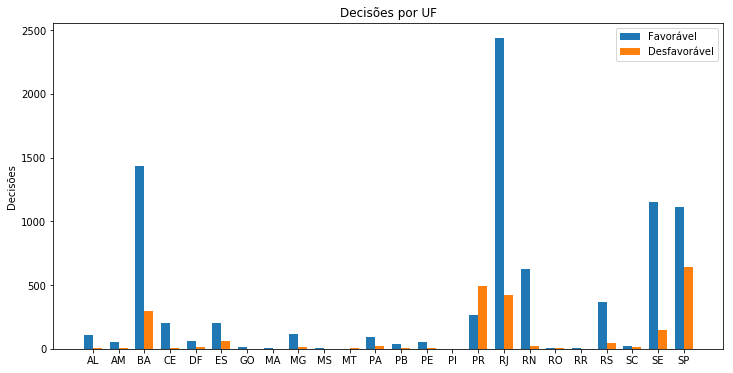

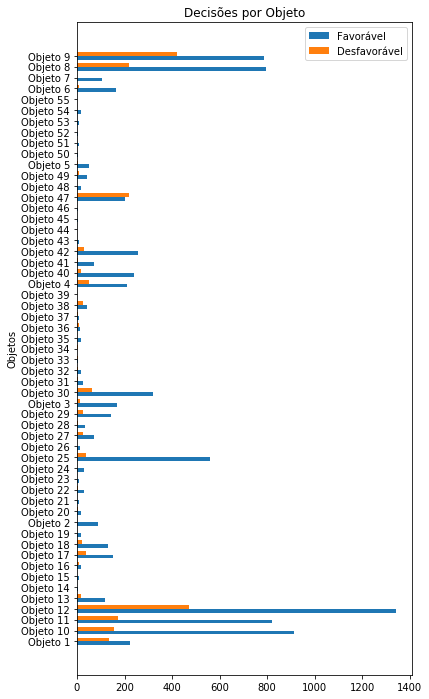

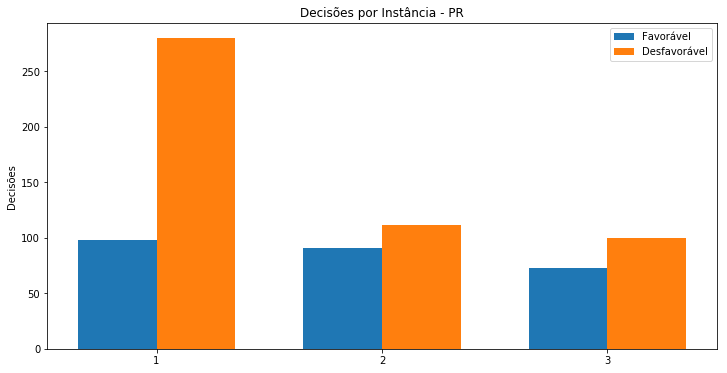

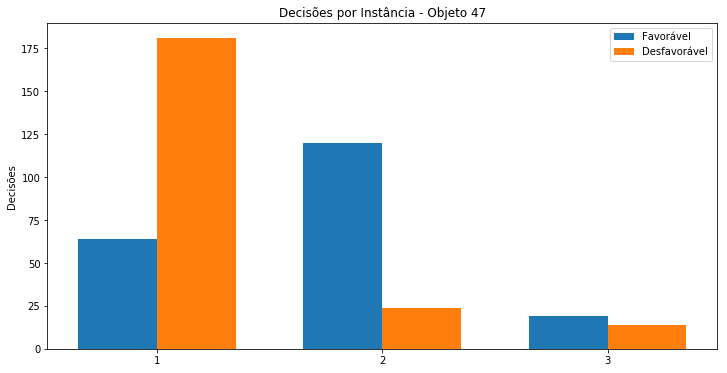

In [22]:
# Gráficos:
# Decisão por UF:
dff = dff.astype(str)
dff_UF_Decisao = dff[['UF', 'Decisão', 'Instância']]
dff_UF_Decisao = dff_UF_Decisao.groupby(['UF', 'Decisão'], as_index = False).count().sort_values(
                      by='Decisão', ascending=False)
dff_UF_Decisao = dff_UF_Decisao.pivot_table(index='UF',columns='Decisão',aggfunc=sum).reset_index()
dff_UF_Decisao.columns = ['UF','Desfavorável', 'Favorável']
ind = np.arange(dff_UF_Decisao['UF'].count())
width = 0.35
plt.figure(figsize = (12, 6))      
plt.bar(ind, dff_UF_Decisao['Favorável'], width, label='Favorável')
plt.bar(ind + width, dff_UF_Decisao['Desfavorável'], width, label='Desfavorável')
plt.ylabel('Decisões')
plt.title('Decisões por UF')
plt.xticks(ind + width / 2, dff_UF_Decisao['UF'].tolist())
plt.legend(loc='best')
plt.show()

# Decisão por Objeto:
dff_Objeto_Decisao = dff[['UF', 'Decisão', 'Objeto']]
dff_Objeto_Decisao = dff_Objeto_Decisao.groupby(['Objeto', 'Decisão'], as_index = False).count().sort_values(
                      by='Decisão', ascending=False)
dff_Objeto_Decisao = dff_Objeto_Decisao.pivot_table(index='Objeto',columns='Decisão',aggfunc=sum).reset_index()
dff_Objeto_Decisao.columns = ['Objeto','Desfavorável', 'Favorável']
ind = np.arange(dff_Objeto_Decisao['Objeto'].count())
width = 0.35
plt.figure(figsize = (6, 12))      
plt.barh(ind, dff_Objeto_Decisao['Favorável'], width, label='Favorável')
plt.barh(ind + width, dff_Objeto_Decisao['Desfavorável'], width, label='Desfavorável')
plt.ylabel('Objetos')
plt.title('Decisões por Objeto')
plt.yticks(ind + width / 2, dff_Objeto_Decisao['Objeto'].tolist())
plt.legend(loc='best')
plt.show()

# Decisão por Instância (PR):
dff = dff.astype(str)
dff_Instância_Decisao = dff[['UF', 'Decisão', 'Instância']]
dff_Instância_Decisao = dff_Instância_Decisao[dff_Instância_Decisao['UF'] == 'PR']
dff_Instância_Decisao = dff_Instância_Decisao.groupby(['Instância', 'Decisão'], as_index = False).count().sort_values(
                      by='Decisão', ascending=False)
dff_Instância_Decisao = dff_Instância_Decisao.pivot_table(index='Instância',columns='Decisão',aggfunc=sum).reset_index()
dff_Instância_Decisao.columns = ['Instância','Desfavorável', 'Favorável']
ind = np.arange(dff_Instância_Decisao['Instância'].count())
width = 0.35
plt.figure(figsize = (12, 6))      
plt.bar(ind, dff_Instância_Decisao['Favorável'], width, label='Favorável')
plt.bar(ind + width, dff_Instância_Decisao['Desfavorável'], width, label='Desfavorável')
plt.ylabel('Decisões')
plt.title('Decisões por Instância - PR')
plt.xticks(ind + width / 2, dff_Instância_Decisao['Instância'].tolist())
plt.legend(loc='best')
plt.show()

# Decisão por Instância (Objeto 47):
dff = dff.astype(str)
dff_Instância_Decisao_2 = dff[['Objeto', 'Decisão', 'Instância']]
dff_Instância_Decisao_2 = dff_Instância_Decisao_2[dff_Instância_Decisao_2['Objeto'] == 'Objeto 47']
dff_Instância_Decisao_2 = dff_Instância_Decisao_2.groupby(['Instância', 'Decisão'], as_index = False).count().sort_values(
                      by='Decisão', ascending=False)
dff_Instância_Decisao_2 = dff_Instância_Decisao_2.pivot_table(index='Instância',columns='Decisão',aggfunc=sum).reset_index()
dff_Instância_Decisao_2.columns = ['Instância','Desfavorável', 'Favorável']
ind = np.arange(dff_Instância_Decisao_2['Instância'].count())
width = 0.35
plt.figure(figsize = (12, 6))      
plt.bar(ind, dff_Instância_Decisao_2['Favorável'], width, label='Favorável')
plt.bar(ind + width, dff_Instância_Decisao_2['Desfavorável'], width, label='Desfavorável')
plt.ylabel('Decisões')
plt.title('Decisões por Instância - Objeto 47')
plt.xticks(ind + width / 2, dff_Instância_Decisao_2['Instância'].tolist())
plt.legend(loc='best')
plt.show()

##### 5- Aplicação dos Modelos
Vamos analisar 3 modelos diferentes: Decision Tree, Random Forest e Gradient Boosting.

In [23]:
# Separação dos dados em Treino e Teste e transformação em Dummies:
X = dff.drop('Decisão', axis=1)
X = pd.get_dummies(X, prefix_sep = '_', drop_first = True)
y = pd.DataFrame(dff['Decisão'])
y = pd.get_dummies(y, prefix_sep = '_', drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print('X_train(Linhas, Colunas): {}'.format(X_train.shape))
print('X_test(Linhas, Colunas): {}'.format(X_test.shape))
print('y_train(Linhas, Colunas): {}'.format(y_train.shape))
print('y_test(Linhas, Colunas): {}'.format(y_test.shape))

X_train(Linhas, Colunas): (7961, 82)
X_test(Linhas, Colunas): (2654, 82)
y_train(Linhas, Colunas): (7961, 1)
y_test(Linhas, Colunas): (2654, 1)


In [24]:
# Normalizar os dados para melhorar o desempenho dos algoritmos:
sc = StandardScaler()
X_train_scaler = sc.fit_transform(X_train)  
X_test_scaler = sc.transform(X_test)

C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\ramon\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


###### 5.1- Decision Tree

In [26]:
# Criar o modelo Decision Tree: 
# max_depth: Determina a profundidade máxima da árvore.
# min_samples_leaf: O número mínimo de amostras necessárias para ser considerado um nó folha.
# Encontrar os hiperparâmetros do modelo de maior accuracy:
dt = DecisionTreeClassifier()
clf = Pipeline([('scaler', sc), ('dt', dt)])
random_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__splitter': ['best', 'random'],
    'dt__max_depth': [None, 5, 8, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 5, 10],
    'dt__random_state': [0, None, 5, 42]}

search = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, 
                            n_iter = 200, cv = 5, verbose = 10, n_jobs = -1)
results = search.fit(X_train, y_train)
results.best_score_, results.best_params_, results.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

(0.841225976636101,
 {'dt__splitter': 'random',
  'dt__random_state': 5,
  'dt__min_samples_split': 10,
  'dt__min_samples_leaf': 10,
  'dt__max_depth': 8,
  'dt__criterion': 'entropy'},
 Pipeline(memory=None,
      steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=10,
             min_weight_fraction_leaf=0.0, presort=False, random_state=5,
             splitter='random'))]))

In [50]:
# Treinar modelo com os hiperparâmetros definidos:
clf = DecisionTreeClassifier(random_state = 5,
                         splitter='random',
                         criterion='entropy',
                         max_depth=8, 
                         min_samples_split=10,
                         min_samples_leaf=10)
clf.fit(X_train_scaler, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=5,
            splitter='random')

In [51]:
# Verificar intervalo possível de acurácia, precisão e recall:
intervalo_accuracy(clf, X_train_scaler, y_train)
print('')
intervalo_precisao(clf, X_train_scaler, y_train)
print('')
intervalo_recall(clf, X_train_scaler, y_train)

Acurácia média: 83.70%
Intervalo de acurácia: [81.93% ~ 85.46%]

Precisão média: 85.56%
Intervalo de Precisão: [84.86% ~ 86.26%]

Recall média: 95.55%
Intervalo de Recall: [94.50% ~ 96.60%]


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Área sob a curva ROC - Decision Tree: 0.7869


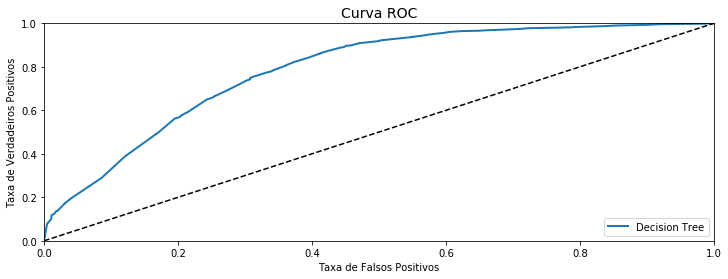

Área sob a curva ROC: 0.7869


In [52]:
# Plotar Curva ROC
y_prob = cross_val_predict(clf, X_train_scaler, y_train, 
                                  cv = cv, method = 'predict_proba')
y_scores = y_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
print('Área sob a curva ROC - Decision Tree: {:.4f}'
      .format(roc_auc_score(y_train, y_scores)))

fig, ax = plt.subplots(figsize = (12,4))
plt.plot(fpr, tpr, linewidth=2, 
         label = 'Decision Tree')
plt.plot([0,1], [0,1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc = 'lower right')
plt.title('Curva ROC', fontsize = 14)
plt.show()

print('Área sob a curva ROC: {:.4f}'
      .format(roc_auc_score(y_train, y_scores)))

In [53]:
# Testar modelo com os hiperparâmetros definidos:
result = clf.predict(X_test_scaler)

In [54]:
# Analisar principais métricas com dados de teste:
cv = StratifiedKFold(n_splits = 5, shuffle = True)
main_metrics_test(y_test, result)

Métricas do conjunto de teste:
accuracy: 0.8376036171816127
f1 score macro: 0.7056413209822884
f1 score micro: 0.8376036171816127
precision score: 0.778711122598432
recall score: 0.6767902963440511
hamming_loss: 0.16239638281838734
classification_report:
              precision    recall  f1-score   support

           0       0.70      0.40      0.51       559
           1       0.86      0.95      0.90      2095

   micro avg       0.84      0.84      0.84      2654
   macro avg       0.78      0.68      0.71      2654
weighted avg       0.82      0.84      0.82      2654

jaccard_similarity_score: 0.8376036171816127
log_loss: 5.609073583625867
zero_one_loss: 0.1623963828183873
AUC&ROC: 0.6767902963440511
matthews_corrcoef: 0.4439523486076403

Matriz de confusão:
[[ 223  336]
 [  95 2000]]


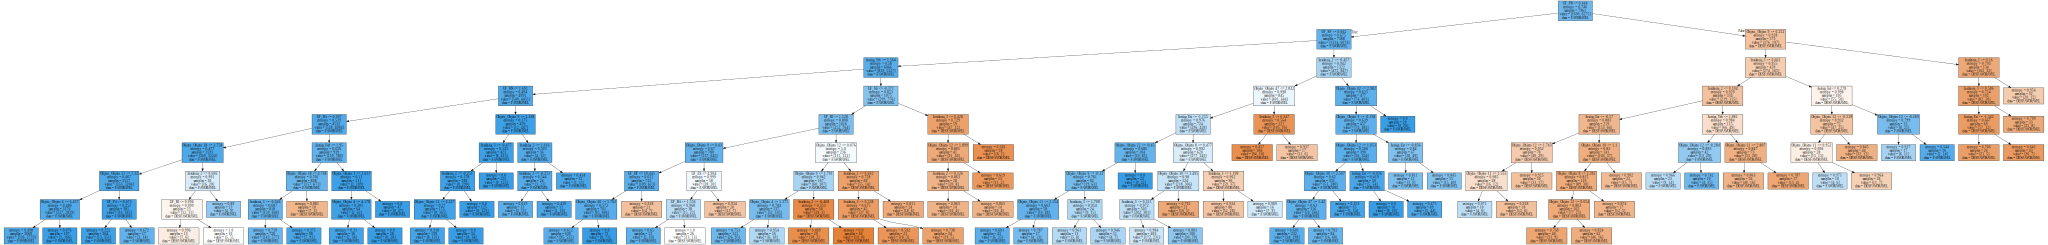

'./graph\\graph.png'

In [55]:
# Gráfico da Árvore de Decisão:
os.environ["PATH"] += os.pathsep + 'C:/Users/ramon/Anaconda3/Library/bin/graphviz/'
graph = Source(tree.export_graphviz(clf, out_file=None, proportion=False,
                                    feature_names=list(X.columns),
                                    class_names=["DESFAVORÁVEL", "FAVORÁVEL"],
                                    filled=True), format="png")
display(SVG(graph.pipe(format='svg')))
graph.render("./graph/graph")

In [56]:
# Visualizar resultados:
print_results('C:/Users/ramon/OneDrive/Documentos/Projetos/Pessoal/DataScience/DataFanProject/modelo_preditivo_decisoes_processos_judiciais/resultados/resultados_decision_tree.xlsx', 
              clf, X_test, y_test, result)

      Decisão_Test            ID     Objeto       Decisão  Instância  \
0        Favorável   EBA.005.036   Objeto 8     Favorável          2   
1     Desfavorável   EPR.002.234   Objeto 9  Desfavorável          2   
2     Desfavorável   ERJ.007.040  Objeto 12  Desfavorável          2   
3        Favorável   ERJ.008.240  Objeto 10     Favorável          2   
4        Favorável  ECE1.000.008   Objeto 9     Favorável          1   
5        Favorável   EBA.004.200  Objeto 30     Favorável          2   
6        Favorável   RJ1.003.343  Objeto 47     Favorável          1   
7     Desfavorável   EES.001.542   Objeto 9  Desfavorável          2   
8        Favorável   EMG.001.872  Objeto 12     Favorável          3   
9     Desfavorável   EPR.003.013  Objeto 25     Favorável          1   
10       Favorável   ESE.003.956  Objeto 25     Favorável          1   
11       Favorável   EES.001.156   Objeto 9     Favorável          3   
12       Favorável   EAL.001.324   Objeto 9     Favorável       

###### 5.2- Random Forest

In [36]:
# Criar o modelo de Floresta Aleatória:
# Encontrar os hiperparâmetros do modelo de maior accuracy:
rf = RandomForestClassifier()
clf = Pipeline([('scaler', sc), ('rf', rf)])
random_grid = {
    'rf__criterion': ['gini', 'entropy'],
    'rf__n_estimators': [10, 100, 200, 300],
    'rf__max_depth': [None, 5, 8, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 5, 10],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__n_jobs': [-1],
    'rf__verbose': [10],
    'rf__random_state': [0, None, 5, 42]}

search = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, 
                            n_iter = 20, cv = 5, verbose = 10, n_jobs = -1)
results = search.fit(X_train, y_train)
results.best_score_, results.best_params_, results.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   32.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.6s finished
C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\U

building tree 1 of 200building tree 2 of 200building tree 3 of 200


building tree 4 of 200building tree 5 of 200building tree 6 of 200building tree 7 of 200
building tree 8 of 200



building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200building tree 13 of 200
building tree 14 of 200

building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    0.3s



building tree 26 of 200
building tree 27 of 200
building tree 28 of 200building tree 29 of 200
building tree 30 of 200building tree 31 of 200

building tree 32 of 200

building tree 33 of 200
building tree 34 of 200
building tree 35 of 200building tree 36 of 200

building tree 37 of 200building tree 38 of 200
building tree 39 of 200

building tree 40 of 200
building tree 41 of 200
building tree 42 of 200building tree 43 of 200

building tree 44 of 200building tree 45 of 200

building tree 46 of 200
building tree 47 of 200
building tree 48 of 200building tree 49 of 200

building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200building tree 55 of 200

building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200building tree 63 of 200

building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 6

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    0.5s


building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200building tree 101 of 200

building tree 102 of 200building tree 103 of 200

building tree 104 of 200
building tree 105 of 200
building tree 106 of 200building tree 107 of 200

building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200building tree 115 of 200building tree 116 of 200

building tree 117 of 200
building tree 118 of 200

building tree 119 of 200
building tree 120 of 200
building tree 121 of 200building tree 122 of 200

building tree 123 of 200building tree 124 of 200
building tree 125 of 200building tree 126 of 200


building tree 127 of 200
building tree 128 of 200
building tree 129 of 200building tree 130 of 200

building tree 131 of 200building tree 132 of 200building tree 133 of 200


building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
bui

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.7s finished


building tree 169 of 200
building tree 170 of 200

building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200building tree 177 of 200

building tree 178 of 200building tree 179 of 200

building tree 180 of 200building tree 181 of 200

building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200building tree 189 of 200
building tree 190 of 200
building tree 191 of 200

building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200building tree 197 of 200
building tree 198 of 200building tree 199 of 200

building tree 200 of 200



(0.8423564878784072,
 {'rf__verbose': 10,
  'rf__random_state': 5,
  'rf__n_jobs': -1,
  'rf__n_estimators': 200,
  'rf__min_samples_split': 5,
  'rf__min_samples_leaf': 1,
  'rf__max_features': 'auto',
  'rf__max_depth': 20,
  'rf__criterion': 'gini'},
 Pipeline(memory=None,
      steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=20, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
             oob_score=False, random_state=5, verbose=10, warm_start=False))]))

In [37]:
# Treinar modelo com os hiperparâmetros definidos:
rf = RandomForestClassifier (bootstrap=True, criterion='gini', max_depth=20,
                                        max_features='auto',
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=5,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=5, verbose=10)
rf.fit(X_train_scaler, y_train)

C:\Users\ramon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200building tree 4 of 200
building tree 5 of 200

building tree 6 of 200
building tree 7 of 200building tree 8 of 200

building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200building tree 13 of 200

building tree 14 of 200
building tree 15 of 200building tree 16 of 200

building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200building tree 21 of 200

building tree 22 of 200building tree 23 of 200

building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200building tree 30 of 200

building tree 31 of 200
building tree 32 of 200building tree 33 of 200

building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s



building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200building tree 56 of 200
building tree 57 of 200

building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200building tree 67 of 200

building tree 68 of 200
building tree 69 of 200building tree 70 of 200

building tree 71 of 200
building tree 72 of 200building tree 73 of 200

building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200building tree 81 of 200

building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200building tree 89 of 200

building tree 90 of 200building tree 91 of 200building tree 92 of 200


building tree 9

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.3s



building tree 111 of 200building tree 112 of 200building tree 113 of 200


building tree 114 of 200building tree 115 of 200building tree 116 of 200


building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200building tree 122 of 200

building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200building tree 134 of 200

building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200building tree 144 of 200

building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200building tree 150 of 200


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s


building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200building tree 184 of 200

building tree 185 of 200
building tree 186 of 200building tree 187 of 200

building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200building tree 194 of 200

building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200building tree 199 of 200
building tree 200 of 200



[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=5, verbose=10, warm_start=False)

In [41]:
# Verificar intervalo possível de acurácia, precisão e recall:
intervalo_accuracy(rf, X_train_scaler, y_train)

C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0329s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 164 out of 200 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1580s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0708s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1836s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 conc

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\model_selection\_validati

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0604s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1406s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0469s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1436s.) Setting batch_size=22.
[Parallel(n_jobs=-1)]: Done  80 out of 200 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tas

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
Acurácia média: 84.24%
Intervalo de acurácia: [83.31% ~ 85.16%]


In [42]:
intervalo_precisao(rf, X_train_scaler, y_train)

C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1311s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0560s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parall

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0748s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0858s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done  80 out of 200 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 164 out of 200 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jo

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0333s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1496s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1027s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1162s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0329s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1656s.) Setting batch_size=28.
[Parallel(n_jobs=-1)]: Done 164 out of 200 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
Precisão média: 86.12%
Intervalo de Precisão: [84.78% ~ 87.47%]


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Para

In [43]:
intervalo_recall(rf, X_train_scaler, y_train)

C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0559s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1172s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Paralle

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1017s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0710s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parall

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0568s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1540s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0509s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1170s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0472s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1476s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done  80 out of 200 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tas

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
Recall média: 95.46%
Intervalo de Recall: [93.71% ~ 97.21%]


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1436s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0678s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1579s.) Setting batch_size=24.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1989s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0758s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0549s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1421s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0585s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1188s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
Área sob a curva ROC - Random Forest: 0.8283


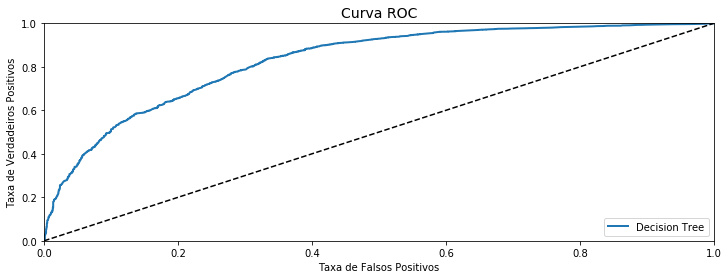

Área sob a curva ROC: 0.8283


In [44]:
# Plotar Curva ROC
y_prob = cross_val_predict(rf, X_train_scaler, y_train, 
                                  cv = cv, method = 'predict_proba')
y_scores = y_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
print('Área sob a curva ROC - Random Forest: {:.4f}'
      .format(roc_auc_score(y_train, y_scores)))

fig, ax = plt.subplots(figsize = (12,4))
plt.plot(fpr, tpr, linewidth=2, 
         label = 'Decision Tree')
plt.plot([0,1], [0,1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc = 'lower right')
plt.title('Curva ROC', fontsize = 14)
plt.show()

print('Área sob a curva ROC: {:.4f}'
      .format(roc_auc_score(y_train, y_scores)))

In [45]:
# Testar modelo com os parâmetros definidos:
result = rf.predict(X_test_scaler)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Para

In [46]:
# Analisar principais métricas com dados de teste:
cv = StratifiedKFold(n_splits = 5, shuffle = True)
main_metrics_test(y_test, result)

Métricas do conjunto de teste:
accuracy: 0.8428786737000754
f1 score macro: 0.7167545156151026
f1 score micro: 0.8428786737000754
precision score: 0.7896108196895035
recall score: 0.6866894941102634
hamming_loss: 0.15712132629992465
classification_report:
              precision    recall  f1-score   support

           0       0.72      0.42      0.53       559
           1       0.86      0.96      0.91      2095

   micro avg       0.84      0.84      0.84      2654
   macro avg       0.79      0.69      0.72      2654
weighted avg       0.83      0.84      0.83      2654

jaccard_similarity_score: 0.8428786737000754
log_loss: 5.426876573263
zero_one_loss: 0.1571213262999246
AUC&ROC: 0.6866894941102634
matthews_corrcoef: 0.46504751334328026

Matriz de confusão:
[[ 233  326]
 [  91 2004]]


In [48]:
# Visualizar resultados:
print_results('C:/Users/ramon/OneDrive/Documentos/Projetos/Pessoal/DataScience/DataFanProject/modelo_preditivo_decisoes_processos_judiciais/resultados/resultados_random_forest.xlsx', 
              rf, X_test, y_test, result)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Para

      Decisão_Test            ID     Objeto       Decisão  Instância  \
0        Favorável   EBA.005.036   Objeto 8     Favorável          2   
1     Desfavorável   EPR.002.234   Objeto 9  Desfavorável          2   
2     Desfavorável   ERJ.007.040  Objeto 12  Desfavorável          2   
3        Favorável   ERJ.008.240  Objeto 10     Favorável          2   
4        Favorável  ECE1.000.008   Objeto 9     Favorável          1   
5        Favorável   EBA.004.200  Objeto 30     Favorável          2   
6        Favorável   RJ1.003.343  Objeto 47     Favorável          1   
7     Desfavorável   EES.001.542   Objeto 9  Desfavorável          2   
8        Favorável   EMG.001.872  Objeto 12     Favorável          3   
9     Desfavorável   EPR.003.013  Objeto 25     Favorável          1   
10       Favorável   ESE.003.956  Objeto 25     Favorável          1   
11       Favorável   EES.001.156   Objeto 9     Favorável          3   
12       Favorável   EAL.001.324   Objeto 9     Favorável       

###### 5.3- Gradient Boosting

In [ ]:
# Criar o modelo de Gradient Boosting:
# Encontrar os parâmetros do modelo de maior accuracy:
gb = GradientBoostingClassifier()
clf = Pipeline([('scaler', sc), ('gb', gb)])
random_grid = {
    'gb__criterion': ['friedman_mse', 'mse', 'mae'],
    'gb__learning_rate':[0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
    'gb__n_estimators': [10, 100, 200, 300],
    'gb__max_depth': [None, 5, 8, 20],
    'gb__min_samples_split': [2, 5, 10],
    'gb__min_samples_leaf': [1, 5, 10],
    'gb__max_features': ['auto', 'sqrt', 'log2'],
    'gb__random_state': [0, None, 5, 42]}

search = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, 
                            n_iter = 20, cv = 5, verbose = 10, n_jobs = -1)
results = search.fit(X_train, y_train)
results.best_score_, results.best_params_, results.best_estimator_

In [58]:
# Treinar modelo com os parâmetros definidos:
gb = GradientBoostingClassifier(criterion='friedman_mse', max_depth=20,
                                        max_features='auto',
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=10,
                                        n_estimators=200,
                                        random_state=5, verbose=10)
gb.fit(X_train_scaler, y_train)
result = gb.predict(X_test)

C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9631           43.34s
         2           0.9107           43.57s
         3           0.8710           41.02s
         4           0.8383           39.60s
         5           0.8102           40.92s
         6           0.7868           41.62s
         7           0.7676           42.98s
         8           0.7517           43.34s
         9           0.7376           43.71s
        10           0.7264           43.12s
        11           0.7164           42.76s
        12           0.7067           42.69s
        13           0.6982           43.07s
        14           0.6908           43.41s
        15           0.6847           42.67s
        16           0.6787           42.63s
        17           0.6739           42.70s
        18           0.6701           42.93s
        19           0.6659           42.61s
        20           0.6625           42.22s
        21           0.6593           42.04s
        2

       183           0.6016            2.71s
       184           0.6015            2.55s
       185           0.6015            2.39s
       186           0.6014            2.23s
       187           0.6014            2.08s
       188           0.6013            1.92s
       189           0.6013            1.77s
       190           0.6012            1.60s
       191           0.6012            1.45s
       192           0.6012            1.29s
       193           0.6011            1.13s
       194           0.6011            0.96s
       195           0.6011            0.80s
       196           0.6010            0.64s
       197           0.6009            0.48s
       198           0.6009            0.32s
       199           0.6008            0.16s
       200           0.6008            0.00s


In [60]:
# Verificar intervalo possível de acurácia, precisão e recall:
intervalo_accuracy(gb, X_train_scaler, y_train)

C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9603           34.97s
         2           0.9076           35.87s
         3           0.8666           36.82s
         4           0.8335           36.53s
         5           0.8063           36.55s
         6           0.7827           35.88s
         7           0.7631           35.13s
         8           0.7456           36.04s
         9           0.7310           36.49s
        10           0.7190           36.70s
        11           0.7087           36.77s
        12           0.6992           35.75s
        13           0.6917           35.81s
        14           0.6840           35.68s
        15           0.6778           35.81s
        16           0.6713           35.69s
        17           0.6658           35.53s
        18           0.6613           34.83s
        19           0.6573           34.46s
        20           0.6537           33.72s
        21           0.6497           33.19s
        2

       183           0.5843            2.43s
       184           0.5842            2.29s
       185           0.5842            2.14s
       186           0.5841            2.00s
       187           0.5841            1.86s
       188           0.5840            1.72s
       189           0.5840            1.57s
       190           0.5839            1.43s
       191           0.5838            1.29s
       192           0.5837            1.14s
       193           0.5837            1.00s
       194           0.5836            0.86s
       195           0.5836            0.71s
       196           0.5835            0.57s
       197           0.5835            0.43s
       198           0.5835            0.28s
       199           0.5834            0.14s
       200           0.5834            0.00s


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9602           30.21s
         2           0.9073           27.63s
         3           0.8666           29.91s
         4           0.8337           30.83s
         5           0.8068           32.31s
         6           0.7835           33.07s
         7           0.7639           33.88s
         8           0.7456           34.53s
         9           0.7314           33.99s
        10           0.7181           33.60s
        11           0.7067           32.58s
        12           0.6976           31.76s
        13           0.6884           31.20s
        14           0.6806           31.78s
        15           0.6746           31.85s
        16           0.6690           31.28s
        17           0.6644           31.19s
        18           0.6587           31.51s
        19           0.6547           31.67s
        20           0.6507           31.58s
        21           0.6470           31.67s
        2

       184           0.5873            2.32s
       185           0.5872            2.18s
       186           0.5872            2.03s
       187           0.5872            1.89s
       188           0.5871            1.74s
       189           0.5871            1.60s
       190           0.5870            1.45s
       191           0.5870            1.31s
       192           0.5870            1.16s
       193           0.5869            1.02s
       194           0.5869            0.87s
       195           0.5869            0.73s
       196           0.5868            0.58s
       197           0.5868            0.43s
       198           0.5868            0.29s
       199           0.5867            0.14s
       200           0.5867            0.00s


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9609           39.98s
         2           0.9079           37.50s
         3           0.8676           36.48s
         4           0.8355           34.99s
         5           0.8077           35.10s
         6           0.7847           35.55s
         7           0.7648           35.79s
         8           0.7483           35.91s
         9           0.7336           35.84s
        10           0.7208           34.83s
        11           0.7103           34.56s
        12           0.7007           34.86s
        13           0.6916           34.86s
        14           0.6844           34.91s
        15           0.6779           34.69s
        16           0.6714           34.34s
        17           0.6663           34.27s
        18           0.6617           34.15s
        19           0.6578           33.91s
        20           0.6545           33.86s
        21           0.6511           33.43s
        2

       183           0.5864            2.54s
       184           0.5864            2.39s
       185           0.5863            2.24s
       186           0.5863            2.09s
       187           0.5863            1.94s
       188           0.5862            1.79s
       189           0.5862            1.64s
       190           0.5861            1.49s
       191           0.5860            1.34s
       192           0.5860            1.19s
       193           0.5859            1.05s
       194           0.5859            0.90s
       195           0.5859            0.75s
       196           0.5859            0.60s
       197           0.5858            0.45s
       198           0.5858            0.30s
       199           0.5858            0.15s
       200           0.5857            0.00s
      Iter       Train Loss   Remaining Time 


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9603           39.16s
         2           0.9070           39.14s
         3           0.8653           39.47s
         4           0.8311           37.57s
         5           0.8022           36.41s
         6           0.7796           36.86s
         7           0.7608           37.00s
         8           0.7433           37.38s
         9           0.7286           37.46s
        10           0.7161           36.61s
        11           0.7055           35.39s
        12           0.6961           34.74s
        13           0.6878           33.85s
        14           0.6805           33.91s
        15           0.6730           34.18s
        16           0.6667           33.96s
        17           0.6618           33.29s
        18           0.6575           33.17s
        19           0.6537           33.22s
        20           0.6493           33.33s
        21           0.6460           33.23s
        22           0.6430           33.01s
        23

       184           0.5836            2.38s
       185           0.5836            2.23s
       186           0.5836            2.09s
       187           0.5835            1.94s
       188           0.5835            1.79s
       189           0.5835            1.64s
       190           0.5834            1.49s
       191           0.5834            1.34s
       192           0.5834            1.19s
       193           0.5834            1.04s
       194           0.5833            0.89s
       195           0.5833            0.74s
       196           0.5832            0.59s
       197           0.5832            0.44s
       198           0.5832            0.30s
       199           0.5832            0.15s
       200           0.5831            0.00s
      Iter       Train Loss   Remaining Time 


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9615           34.06s
         2           0.9100           36.52s
         3           0.8694           34.82s
         4           0.8359           35.72s
         5           0.8083           36.08s
         6           0.7853           35.44s
         7           0.7661           34.24s
         8           0.7486           34.43s
         9           0.7352           34.76s
        10           0.7222           34.82s
        11           0.7103           34.76s
        12           0.7004           34.37s
        13           0.6925           34.02s
        14           0.6847           33.95s
        15           0.6781           33.87s
        16           0.6728           34.00s
        17           0.6681           34.18s
        18           0.6633           33.69s
        19           0.6592           33.27s
        20           0.6553           33.28s
        21           0.6518           33.15s
        22           0.6495           32.76s
        23

       185           0.5878            2.00s
       186           0.5878            1.87s
       187           0.5877            1.73s
       188           0.5877            1.60s
       189           0.5876            1.46s
       190           0.5876            1.33s
       191           0.5875            1.20s
       192           0.5875            1.06s
       193           0.5874            0.93s
       194           0.5874            0.80s
       195           0.5874            0.66s
       196           0.5874            0.53s
       197           0.5873            0.40s
       198           0.5873            0.26s
       199           0.5872            0.13s
       200           0.5872            0.00s
Acurácia média: 83.66%
Intervalo de acurácia: [82.67% ~ 84.64%]


In [61]:
intervalo_precisao(gb, X_train_scaler, y_train)

C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9602           25.42s
         2           0.9076           30.67s
         3           0.8670           32.51s
         4           0.8345           31.88s
         5           0.8067           33.25s
         6           0.7833           33.55s
         7           0.7633           34.10s
         8           0.7473           34.20s
         9           0.7327           34.39s
        10           0.7203           33.97s
        11           0.7098           33.97s
        12           0.7009           33.63s
        13           0.6921           33.45s
        14           0.6842           33.51s
        15           0.6767           33.45s
        16           0.6704           32.73s
        17           0.6653           31.97s
        18           0.6607           31.44s
        19           0.6562           30.95s
        20           0.6527           30.68s
        21           0.6487           30.46s
        2

       184           0.5869            2.39s
       185           0.5869            2.25s
       186           0.5869            2.10s
       187           0.5869            1.95s
       188           0.5868            1.80s
       189           0.5868            1.65s
       190           0.5867            1.50s
       191           0.5867            1.35s
       192           0.5867            1.20s
       193           0.5867            1.05s
       194           0.5866            0.90s
       195           0.5866            0.75s
       196           0.5866            0.60s
       197           0.5866            0.45s
       198           0.5866            0.30s
       199           0.5865            0.15s
       200           0.5865            0.00s


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9590           29.40s
         2           0.9055           35.14s
         3           0.8640           32.67s
         4           0.8296           34.29s
         5           0.8014           35.00s
         6           0.7788           35.06s
         7           0.7592           35.65s
         8           0.7427           35.77s
         9           0.7281           34.78s
        10           0.7157           34.96s
        11           0.7053           35.11s
        12           0.6952           34.97s
        13           0.6857           34.80s
        14           0.6786           34.68s
        15           0.6712           33.99s
        16           0.6649           34.15s
        17           0.6594           33.94s
        18           0.6545           33.58s
        19           0.6505           33.58s
        20           0.6464           33.46s
        21           0.6429           33.07s
        2

       184           0.5780            2.29s
       185           0.5779            2.15s
       186           0.5778            2.00s
       187           0.5778            1.86s
       188           0.5777            1.71s
       189           0.5776            1.57s
       190           0.5776            1.43s
       191           0.5776            1.28s
       192           0.5776            1.14s
       193           0.5775            1.00s
       194           0.5775            0.85s
       195           0.5775            0.71s
       196           0.5774            0.57s
       197           0.5774            0.43s
       198           0.5774            0.28s
       199           0.5774            0.14s
       200           0.5773            0.00s
      Iter       Train Loss   Remaining Time 


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9598           34.14s
         2           0.9056           37.45s
         3           0.8634           37.57s
         4           0.8293           37.11s
         5           0.8013           37.62s
         6           0.7784           36.49s
         7           0.7590           36.62s
         8           0.7420           36.49s
         9           0.7273           36.64s
        10           0.7144           36.76s
        11           0.7030           36.55s
        12           0.6931           35.22s
        13           0.6845           35.25s
        14           0.6773           35.12s
        15           0.6710           34.86s
        16           0.6647           34.06s
        17           0.6590           33.37s
        18           0.6552           33.63s
        19           0.6517           33.21s
        20           0.6475           32.51s
        21           0.6444           31.84s
        22           0.6409           31.26s
        23

       184           0.5808            2.29s
       185           0.5808            2.14s
       186           0.5807            2.01s
       187           0.5807            1.86s
       188           0.5806            1.72s
       189           0.5806            1.58s
       190           0.5805            1.43s
       191           0.5805            1.29s
       192           0.5805            1.15s
       193           0.5804            1.01s
       194           0.5803            0.86s
       195           0.5803            0.72s
       196           0.5803            0.58s
       197           0.5802            0.43s
       198           0.5802            0.29s
       199           0.5801            0.14s
       200           0.5801            0.00s
      Iter       Train Loss   Remaining Time 


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9630           29.63s
         2           0.9121           34.54s
         3           0.8707           35.76s
         4           0.8382           36.12s
         5           0.8114           36.72s
         6           0.7875           36.89s
         7           0.7673           35.93s
         8           0.7506           34.72s
         9           0.7363           33.66s
        10           0.7244           32.98s
        11           0.7129           33.69s
        12           0.7036           33.80s
        13           0.6952           33.21s
        14           0.6879           32.68s
        15           0.6820           32.59s
        16           0.6758           32.31s
        17           0.6709           32.00s
        18           0.6663           31.87s
        19           0.6627           31.74s
        20           0.6597           31.25s
        21           0.6557           31.32s
        22           0.6532           31.37s
        23

       185           0.5947            2.13s
       186           0.5947            1.99s
       187           0.5947            1.84s
       188           0.5946            1.70s
       189           0.5946            1.56s
       190           0.5945            1.42s
       191           0.5945            1.28s
       192           0.5944            1.14s
       193           0.5944            0.99s
       194           0.5944            0.85s
       195           0.5943            0.71s
       196           0.5943            0.57s
       197           0.5943            0.43s
       198           0.5942            0.28s
       199           0.5941            0.14s
       200           0.5940            0.00s
      Iter       Train Loss   Remaining Time 


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9606           38.12s
         2           0.9082           39.32s
         3           0.8672           39.50s
         4           0.8343           39.12s
         5           0.8075           37.17s
         6           0.7844           37.19s
         7           0.7648           37.22s
         8           0.7481           37.57s
         9           0.7335           37.62s
        10           0.7206           37.28s
        11           0.7096           36.48s
        12           0.6997           36.50s
        13           0.6912           36.54s
        14           0.6839           36.49s
        15           0.6770           36.63s
        16           0.6711           35.87s
        17           0.6660           35.52s
        18           0.6607           35.43s
        19           0.6562           35.28s
        20           0.6526           35.20s
        21           0.6493           35.09s
        22           0.6468           34.58s
        23

       184           0.5887            2.41s
       185           0.5887            2.26s
       186           0.5886            2.11s
       187           0.5886            1.96s
       188           0.5885            1.81s
       189           0.5884            1.66s
       190           0.5884            1.51s
       191           0.5884            1.36s
       192           0.5884            1.21s
       193           0.5884            1.06s
       194           0.5883            0.90s
       195           0.5883            0.75s
       196           0.5883            0.60s
       197           0.5883            0.45s
       198           0.5883            0.30s
       199           0.5883            0.15s
       200           0.5882            0.00s
Precisão média: 87.42%
Intervalo de Precisão: [86.56% ~ 88.29%]


In [62]:
intervalo_recall(gb, X_train_scaler, y_train)

C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9587           30.79s
         2           0.9048           34.48s
         3           0.8633           36.33s
         4           0.8303           37.31s
         5           0.8034           35.67s
         6           0.7808           34.81s
         7           0.7614           35.39s
         8           0.7444           35.76s
         9           0.7305           35.81s
        10           0.7182           35.94s
        11           0.7082           35.33s
        12           0.6984           34.65s
        13           0.6899           34.66s
        14           0.6826           34.80s
        15           0.6759           34.75s
        16           0.6709           34.57s
        17           0.6660           34.40s
        18           0.6619           34.19s
        19           0.6575           34.05s
        20           0.6538           33.97s
        21           0.6501           33.86s
        2

       184           0.5869            2.37s
       185           0.5868            2.22s
       186           0.5868            2.07s
       187           0.5868            1.93s
       188           0.5867            1.78s
       189           0.5867            1.63s
       190           0.5867            1.48s
       191           0.5866            1.33s
       192           0.5866            1.19s
       193           0.5865            1.04s
       194           0.5864            0.89s
       195           0.5864            0.74s
       196           0.5864            0.59s
       197           0.5864            0.44s
       198           0.5863            0.30s
       199           0.5863            0.15s
       200           0.5863            0.00s
      Iter       Train Loss   Remaining Time 


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9595           37.43s
         2           0.9059           37.79s
         3           0.8643           33.84s
         4           0.8305           34.79s
         5           0.8026           35.44s
         6           0.7798           35.31s
         7           0.7603           33.52s
         8           0.7434           32.22s
         9           0.7292           32.35s
        10           0.7165           32.16s
        11           0.7047           32.41s
        12           0.6946           32.55s
        13           0.6856           32.60s
        14           0.6777           32.65s
        15           0.6717           32.59s
        16           0.6661           32.16s
        17           0.6604           32.43s
        18           0.6555           32.37s
        19           0.6514           32.44s
        20           0.6477           32.42s
        21           0.6449           32.16s
        22           0.6424           31.72s
        23

       185           0.5785            2.26s
       186           0.5785            2.11s
       187           0.5784            1.96s
       188           0.5784            1.80s
       189           0.5783            1.66s
       190           0.5782            1.50s
       191           0.5782            1.35s
       192           0.5781            1.20s
       193           0.5780            1.05s
       194           0.5779            0.90s
       195           0.5779            0.75s
       196           0.5779            0.60s
       197           0.5778            0.45s
       198           0.5777            0.30s
       199           0.5777            0.15s
       200           0.5777            0.00s


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9631           38.41s
         2           0.9123           37.77s
         3           0.8724           36.75s
         4           0.8393           35.03s
         5           0.8122           34.69s
         6           0.7892           34.66s
         7           0.7687           34.40s
         8           0.7518           34.90s
         9           0.7382           34.83s
        10           0.7259           34.28s
        11           0.7148           33.89s
        12           0.7052           33.81s
        13           0.6977           33.64s
        14           0.6901           33.80s
        15           0.6833           33.97s
        16           0.6780           33.36s
        17           0.6730           33.24s
        18           0.6685           32.61s
        19           0.6650           31.90s
        20           0.6614           31.62s
        21           0.6584           31.64s
        2

C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9592           28.35s
         2           0.9059           34.06s
         3           0.8644           35.69s
         4           0.8299           36.41s
         5           0.8024           36.68s
         6           0.7802           35.54s
         7           0.7612           34.58s
         8           0.7425           33.81s
         9           0.7266           34.00s
        10           0.7139           32.86s
        11           0.7019           32.28s
        12           0.6915           31.76s
        13           0.6818           31.99s
        14           0.6739           31.45s
        15           0.6668           30.83s
        16           0.6608           30.54s
        17           0.6557           29.96s
        18           0.6505           29.30s
        19           0.6460           29.29s
        20           0.6419           29.89s
        21           0.6388           29.68s
        22           0.6359           29.69s
        23

       185           0.5771            2.21s
       186           0.5771            2.06s
       187           0.5770            1.91s
       188           0.5768            1.77s
       189           0.5768            1.62s
       190           0.5768            1.47s
       191           0.5768            1.32s
       192           0.5767            1.18s
       193           0.5767            1.03s
       194           0.5766            0.88s
       195           0.5766            0.74s
       196           0.5765            0.59s
       197           0.5765            0.44s
       198           0.5764            0.29s
       199           0.5764            0.15s
       200           0.5764            0.00s
      Iter       Train Loss   Remaining Time 


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           0.9613           32.35s
         2           0.9094           34.76s
         3           0.8693           39.31s
         4           0.8369           39.48s
         5           0.8102           38.77s
         6           0.7869           39.32s
         7           0.7683           39.17s
         8           0.7521           39.17s
         9           0.7368           39.18s
        10           0.7234           38.01s
        11           0.7117           38.11s
        12           0.7018           38.03s
        13           0.6933           38.02s
        14           0.6852           37.72s
        15           0.6780           37.34s
        16           0.6718           36.89s
        17           0.6665           36.59s
        18           0.6622           36.32s
        19           0.6582           36.22s
        20           0.6547           35.97s
        21           0.6509           35.74s
        22           0.6482           35.43s
        23

       185           0.5866            2.26s
       186           0.5866            2.11s
       187           0.5865            1.96s
       188           0.5864            1.81s
       189           0.5863            1.66s
       190           0.5863            1.51s
       191           0.5863            1.36s
       192           0.5862            1.21s
       193           0.5861            1.06s
       194           0.5860            0.91s
       195           0.5860            0.76s
       196           0.5860            0.61s
       197           0.5859            0.45s
       198           0.5859            0.30s
       199           0.5859            0.15s
       200           0.5858            0.00s
Recall média: 92.87%
Intervalo de Recall: [90.97% ~ 94.77%]


C:\Users\ramon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.9596           37.56s
         2           0.9062           31.55s
         3           0.8647           32.72s
         4           0.8304           34.53s
         5           0.8022           35.43s
         6           0.7791           35.70s
         7           0.7586           35.68s
         8           0.7423           34.86s
         9           0.7275           35.25s
        10           0.7148           35.54s
        11           0.7042           35.44s
        12           0.6943           35.14s
        13           0.6856           34.13s
        14           0.6786           33.47s
        15           0.6712           33.33s
        16           0.6647           33.30s
        17           0.6592           33.26s
        18           0.6547           33.17s
        19           0.6506           33.15s
        20           0.6467           32.87s
        21           0.6429           32.55s
        2

       183           0.5853            2.51s
       184           0.5853            2.36s
       185           0.5852            2.21s
       186           0.5852            2.07s
       187           0.5852            1.92s
       188           0.5852            1.77s
       189           0.5852            1.62s
       190           0.5851            1.47s
       191           0.5851            1.33s
       192           0.5851            1.18s
       193           0.5850            1.03s
       194           0.5850            0.88s
       195           0.5849            0.74s
       196           0.5849            0.59s
       197           0.5848            0.44s
       198           0.5847            0.29s
       199           0.5847            0.15s
       200           0.5847            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.9610           35.59s
         2           0.9078           38.01s
         3           0.8672           39.26s
         

       165           0.5968            5.09s
       166           0.5968            4.95s
       167           0.5966            4.80s
       168           0.5966            4.66s
       169           0.5965            4.51s
       170           0.5964            4.36s
       171           0.5963            4.22s
       172           0.5962            4.08s
       173           0.5962            3.93s
       174           0.5962            3.78s
       175           0.5962            3.64s
       176           0.5961            3.49s
       177           0.5961            3.34s
       178           0.5960            3.19s
       179           0.5960            3.05s
       180           0.5959            2.90s
       181           0.5959            2.76s
       182           0.5958            2.61s
       183           0.5958            2.46s
       184           0.5958            2.31s
       185           0.5957            2.16s
       186           0.5957            2.02s
       187

       149           0.5887            7.23s
       150           0.5886            7.08s
       151           0.5885            6.94s
       152           0.5885            6.79s
       153           0.5884            6.66s
       154           0.5884            6.52s
       155           0.5883            6.38s
       156           0.5882            6.23s
       157           0.5882            6.09s
       158           0.5881            5.94s
       159           0.5880            5.81s
       160           0.5880            5.67s
       161           0.5879            5.51s
       162           0.5879            5.36s
       163           0.5877            5.23s
       164           0.5877            5.09s
       165           0.5876            4.95s
       166           0.5876            4.80s
       167           0.5875            4.66s
       168           0.5874            4.51s
       169           0.5873            4.36s
       170           0.5873            4.21s
       171

       131           0.5868            9.75s
       132           0.5867            9.61s
       133           0.5866            9.45s
       134           0.5866            9.28s
       135           0.5865            9.13s
       136           0.5864            8.98s
       137           0.5862            8.85s
       138           0.5862            8.70s
       139           0.5861            8.53s
       140           0.5861            8.38s
       141           0.5860            8.22s
       142           0.5858            8.09s
       143           0.5857            7.95s
       144           0.5857            7.80s
       145           0.5856            7.66s
       146           0.5856            7.52s
       147           0.5855            7.38s
       148           0.5855            7.23s
       149           0.5854            7.10s
       150           0.5853            6.96s
       151           0.5852            6.84s
       152           0.5851            6.70s
       153

       113           0.5917           12.37s
       114           0.5915           12.20s
       115           0.5914           12.04s
       116           0.5913           11.87s
       117           0.5910           11.77s
       118           0.5908           11.59s
       119           0.5907           11.44s
       120           0.5904           11.31s
       121           0.5903           11.13s
       122           0.5901           11.00s
       123           0.5898           10.84s
       124           0.5898           10.66s
       125           0.5897           10.49s
       126           0.5896           10.31s
       127           0.5895           10.17s
       128           0.5894           10.01s
       129           0.5893            9.87s
       130           0.5891            9.72s
       131           0.5890            9.56s
       132           0.5889            9.42s
       133           0.5889            9.25s
       134           0.5888            9.12s
       135

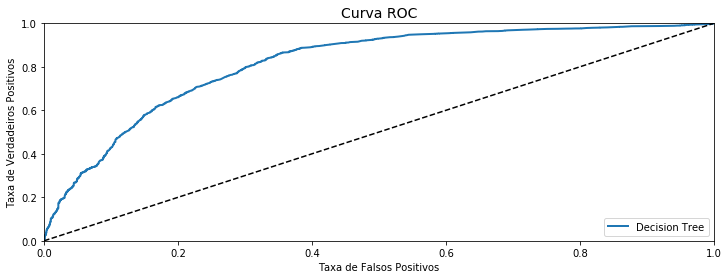

Área sob a curva ROC: 0.8169


In [65]:
# Plotar Curva ROC
y_prob = cross_val_predict(gb, X_train_scaler, y_train, 
                                  cv = cv, method = 'predict_proba')
y_scores = y_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
print('Área sob a curva ROC - Gradient Boosting: {:.4f}'
      .format(roc_auc_score(y_train, y_scores)))

fig, ax = plt.subplots(figsize = (12,4))
plt.plot(fpr, tpr, linewidth=2, 
         label = 'Decision Tree')
plt.plot([0,1], [0,1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc = 'lower right')
plt.title('Curva ROC', fontsize = 14)
plt.show()

print('Área sob a curva ROC: {:.4f}'
      .format(roc_auc_score(y_train, y_scores)))

In [63]:
# Testar modelo com os hiperparâmetros definidos:
result = gb.predict(X_test_scaler)

In [64]:
# Analisar principais métricas com dados de teste:
cv = StratifiedKFold(n_splits = 5, shuffle = True)
main_metrics_test(y_test, result)

Métricas do conjunto de teste:
accuracy: 0.8364732479276563
f1 score macro: 0.7288605909609212
f1 score micro: 0.8364732479276563
precision score: 0.7600043657340738
recall score: 0.7095196417059102
hamming_loss: 0.16352675207234363
classification_report:
              precision    recall  f1-score   support

           0       0.65      0.49      0.56       559
           1       0.87      0.93      0.90      2095

   micro avg       0.84      0.84      0.84      2654
   macro avg       0.76      0.71      0.73      2654
weighted avg       0.82      0.84      0.83      2654

jaccard_similarity_score: 0.8364732479276563
log_loss: 5.648099789245984
zero_one_loss: 0.16352675207234368
AUC&ROC: 0.7095196417059102
matthews_corrcoef: 0.4668019775047042

Matriz de confusão:
[[ 274  285]
 [ 149 1946]]


In [66]:
# Visualizar resultados:
print_results('C:/Users/ramon/OneDrive/Documentos/Projetos/Pessoal/DataScience/DataFanProject/modelo_preditivo_decisoes_processos_judiciais/resultados/resultados_gradient_boosting.xlsx', 
              gb, X_test, y_test, result)

      Decisão_Test            ID     Objeto       Decisão  Instância  \
0        Favorável   EBA.005.036   Objeto 8     Favorável          2   
1     Desfavorável   EPR.002.234   Objeto 9  Desfavorável          2   
2     Desfavorável   ERJ.007.040  Objeto 12  Desfavorável          2   
3        Favorável   ERJ.008.240  Objeto 10     Favorável          2   
4        Favorável  ECE1.000.008   Objeto 9     Favorável          1   
5        Favorável   EBA.004.200  Objeto 30     Favorável          2   
6        Favorável   RJ1.003.343  Objeto 47     Favorável          1   
7     Desfavorável   EES.001.542   Objeto 9  Desfavorável          2   
8        Favorável   EMG.001.872  Objeto 12     Favorável          3   
9     Desfavorável   EPR.003.013  Objeto 25     Favorável          1   
10       Favorável   ESE.003.956  Objeto 25     Favorável          1   
11       Favorável   EES.001.156   Objeto 9     Favorável          3   
12       Favorável   EAL.001.324   Objeto 9     Favorável       